In [12]:
!pip install gcm-filters

In [13]:
!pip install gsw

# Dask start

In [14]:
from dask.distributed import Client, progress

In [15]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40169")
client

<Client: 'tcp://127.0.0.1:40169' processes=4 threads=8, memory=29.40 GiB>

# Import

In [16]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gcm_filters
import gsw
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from importlib import reload

# Load data

Load Pangeo catalog

In [17]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

Winter data:

In [18]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask().chunk({'time_counter':1, 'x' : -1, 'y' : -1})

Summer data:

In [19]:
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask().chunk({'time_counter':1, 'x' : -1, 'y' : -1})

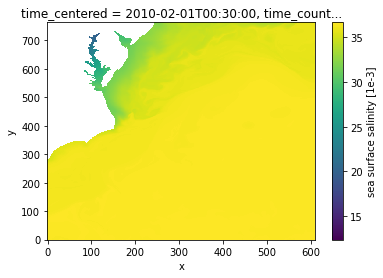

In [20]:
enatl01w.sosaline.isel(time_counter=0).plot()

# Prepare data for filter

## Slicing

In [21]:
enatl01s.time_counter.size

2208

In [11]:
# x_slice = slice(300,600)
# y_slice = slice(400,700)

In [22]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

In [23]:
data_slice = dict(time_counter=slice(0,-1),y=y_slice,x=x_slice)

In [24]:
coord_slice = dict(y=y_slice,x=x_slice)

## Grid

In [25]:
area = xr.DataArray((enatl01w.e1t[coord_slice] * enatl01w.e2t[coord_slice]), dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load()
# area.plot()

Spacings:

In [26]:
dxw = xr.DataArray(enatl01w.e1u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # x-spacing centered at western cell edge

dyw = xr.DataArray(enatl01w.e2u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # y-spacing centered at western cell edge

dxs = xr.DataArray(enatl01w.e1v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # x-spacing centered at southern cell edge

dys = xr.DataArray(enatl01w.e2v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # y-spacing centered at southern cell edge

In [27]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(1289.53776172)

Diffusivities for thefilter in the east-west and north-south directions

In [28]:
kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

## Mask

In [29]:
wet_mask = xr.DataArray(enatl01w.umask[coord_slice],
                        dims=['y','x'],
                        coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
           ).load()

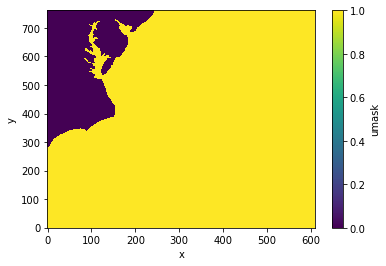

In [30]:
wet_mask.plot()

## High-resolution dataset

In [32]:
dataHR = xr.Dataset({"sst" : enatl01s.sosstsst[data_slice],
                     "sal" : enatl01s.sosaline[data_slice],
                     "wet_mask" : wet_mask},
                    coords=enatl01s[data_slice].coords)

# Filter

## Define filter

Parameters (to determine) :

In [219]:
gaussian_filter = gcm_filters.Filter(
    filter_scale=15000,    # 20 km
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)

In [220]:
# gaussian_filter = gcm_filters.Filter(
#     filter_scale=6,   # 12 grid cells
#     dx_min=1,
#     filter_shape=gcm_filters.FilterShape.GAUSSIAN,
#     grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
#     grid_vars={
#         'wet_mask': wet_mask
#     }
# )

## Apply filter to data

In [221]:
# intermediate dataset: HR data + filtering (result has still the spatial resoltion if HR data)
data_filtered = xr.Dataset({}, coords=enatl01s[data_slice].coords)

"Lazy" filter execution with Dask

In [222]:
data_filtered["sst"] = gaussian_filter.apply(dataHR.sst, dims=['y', 'x'])
data_filtered["sal"] = gaussian_filter.apply(dataHR.sal, dims=['y', 'x'])

# Downsampling (spatial coarsening)

In [227]:
window_size=12

def downsample(data) :
    return data.coarsen(x=window_size, boundary='pad').mean().coarsen(y=window_size,boundary='pad').mean()

In [228]:
dataLR = downsample(data_filtered)

In [229]:
time_counter_to_plot = [1]

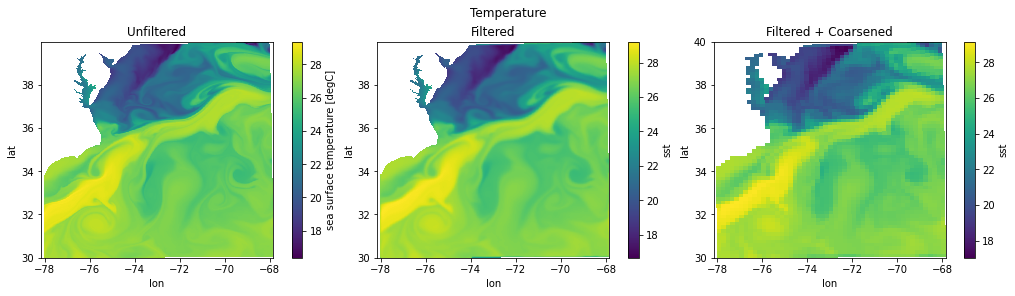

In [230]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
fig.suptitle('Temperature')
(dataHR.isel(time_counter=time_counter_to_plot)).sst.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Unfiltered')
(data_filtered.isel(time_counter=time_counter_to_plot)).sst.plot(ax=ax[1],x='lon', y='lat')
#ax[1].pcolormesh(dataset_filtered.lon, dataset_filtered.lat, dataset_filtered.sst.compute())
ax[1].set(title=r'Filtered')
(dataLR.isel(time_counter=time_counter_to_plot)).sst.plot(ax=ax[2], x='lon', y='lat')
ax[2].set(title=r'Filtered + Coarsened')
plt.show()

In [231]:
# fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
# fig.suptitle('Salinity')
# (dataHR.isel(time_counter=time_counter_to_plot)).sal.plot(ax=ax[0],x='lon', y='lat')
# ax[0].set(title=r'Unfiltered')
# (data_filtered.isel(time_counter=time_counter_to_plot)).sal.plot(ax=ax[1],x='lon', y='lat')
# #ax[1].pcolormesh(dataset_filtered.lon, dataset_filtered.lat, dataset_filtered.sst.compute())
# ax[1].set(title=r'Filtered')
# (dataLR.isel(time_counter=time_counter_to_plot)).sal.plot(ax=ax[2], x='lon', y='lat')
# ax[2].set(title=r'Filtered + Coarsened')
# plt.show()

# Density computation

Convert the HR sea surface temperature to conservative temperature (CT) with the use of ```gsw``` :

In [232]:
dataHR['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, dataHR['sal'], dataHR['sst'], dask='parallelized')

Compute HR density with the use of ```gsw``` library function ```gsw.density.sigma0```. Calculates potential density anomaly with reference pressure of 0 dbar, this being this particular potential density minus 1000 kg/m^3. This function has inputs of Absolute Salinity and Conservative Temperature. This function uses the computationally-efficient expression for specific volume in terms of SA, CT and p (Roquet et al., 2015).

In [233]:
dataHR['sigma0'] = xr.apply_ufunc(gsw.density.sigma0, dataHR['sal'], dataHR['CT'], dask='parallelized')

Apply filter to the density field evaluated with unfiltered salinity and SST:

In [234]:
data_filtered["sigma0_filtered"] = gaussian_filter.apply(dataHR.sigma0, dims=['y', 'x'])

Coarsen the obtained filtered desity field (is actually the density that we would like to reconstrunct):

In [235]:
dataLR["sigma0_filtered"] = downsample(data_filtered["sigma0_filtered"])

Recalculate the density with the EOS using the filtered and coarsened temperature and salinity (density field that would result fron a LR solver and needs co be corrected):

In [236]:
dataLR["CT"] = xr.apply_ufunc(gsw.conversions.CT_from_pt, dataLR['sal'], dataLR['sst'], dask='parallelized')

In [237]:
dataLR["sigma0"] = xr.apply_ufunc(gsw.density.sigma0, dataLR["sal"], dataLR["CT"], dask='parallelized')

In [238]:
dataLR["delta_sigma0"] = dataLR["sigma0_filtered"] - dataLR["sigma0"]

In [239]:
# a slice to cut the borders of the 2D maps 
slice_cut = dict(x=slice(5,-5),y=slice(5,-5))

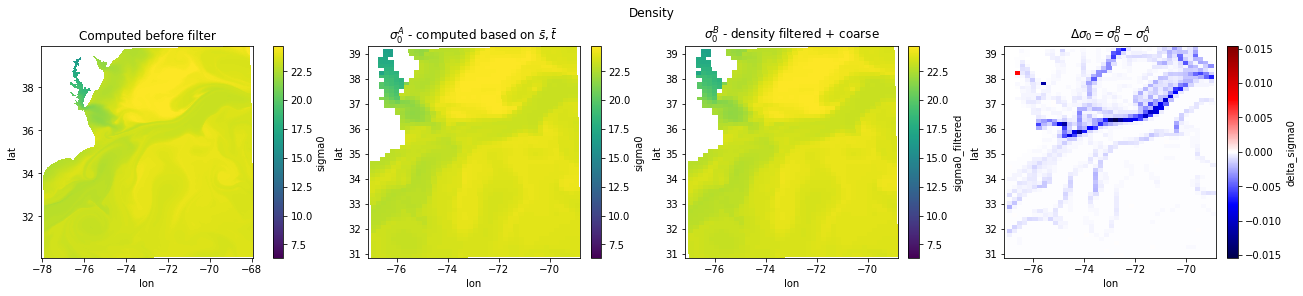

In [240]:
fig, ax = plt.subplots(ncols=4, constrained_layout=True, figsize=(18,4))
fig.suptitle('Density')
heatmap0 = (dataHR[slice_cut].isel(time_counter=time_counter_to_plot)).sigma0.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Computed before filter')

dataLR.isel(time_counter=time_counter_to_plot).sigma0[slice_cut].plot(ax=ax[1], x='lon', y='lat', norm=heatmap0.norm, cmap=heatmap0.cmap)
ax[1].set(title=r'$\sigma_0^A$ - computed based on $\bar{s}, \bar{t}$')

dataLR.isel(time_counter=time_counter_to_plot).sigma0_filtered[slice_cut].plot(ax=ax[2], x='lon', y='lat', norm=heatmap0.norm, cmap=heatmap0.cmap)
ax[2].set(title=r'$\sigma_0^B$ - density filtered + coarse')

dataLR.isel(time_counter=time_counter_to_plot).delta_sigma0[slice_cut].plot(ax=ax[3], x='lon', y='lat', cmap='seismic')
ax[3].set(title=r'$\Delta \sigma_0 = \sigma_0^B - \sigma_0^A$')
plt.show()

# Density derivatives

## Thermal and haline expansion coefficients

In [249]:
dataLR["alpha"], dataLR["beta"] = eos_module.alpha_beta(dataLR["sal"], dataLR["CT"])

In [250]:
# fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
# (dataLR.isel(time_counter=time_counter_to_plot)).alpha[slice_cut].plot(ax=ax[0],x='lon', y='lat')
# ax[0].set(title=r'$\alpha$')
# (dataLR.isel(time_counter=time_counter_to_plot)).beta[slice_cut].plot(ax=ax[1],x='lon', y='lat')
# ax[1].set(title=r'$\beta$')
# plt.show()

# Second derivatives of $\rho$

In [251]:
dataLR['rho_sa_sa'], dataLR['rho_sa_ct'], dataLR['rho_ct_ct'] = eos_module.rho_second_derivatives(dataLR['sal'], dataLR['CT'])

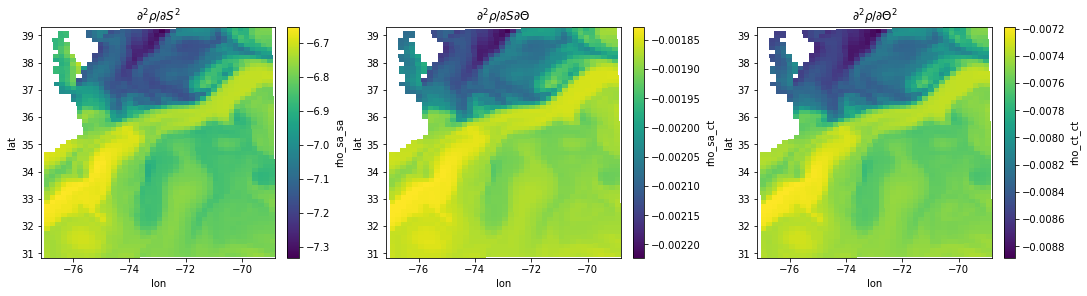

In [252]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(15,4))
(dataLR.isel(time_counter=time_counter_to_plot)).rho_sa_sa[slice_cut].plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'$ \partial^2 \rho/ \partial S^2$')
(dataLR.isel(time_counter=time_counter_to_plot)).rho_sa_ct[slice_cut].plot(ax=ax[1],x='lon', y='lat')
ax[1].set(title=r'$ \partial^2 \rho/ \partial S \partial \Theta$')
(dataLR.isel(time_counter=time_counter_to_plot)).rho_ct_ct[slice_cut].plot(ax=ax[2],x='lon', y='lat')
ax[2].set(title=r'$ \partial^2 \rho/ \partial \Theta^2$')
plt.show()

# Spatial derivatives

In [253]:
# def gradx(dataArray, delta_x) :
#     return (dataArray.shift(x=-1) - dataArray)/delta_x
# def grady(dataArray, delta_y) :
#     return (dataArray.shift(y=-1) - dataArray)/delta_y

In [289]:
def diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [290]:
def diffs2_x(dataArray) :
    dataArray.coords["x_scaled"] = dataArray['x']*dataArray['e1t']
    return dataArray.differentiate("x_scaled")*data.array['e1t']
def diffs2_y(dataArray, delta_y) :
    dataArray.coords["y_scaled"] = dataArray['y']*dataArray['e2t']
    return dataArray.differentiate("y_scaled")*dataArray['e2t']

In [291]:
dataLR['temp_diffs_x'] = diffs_x(dataLR['CT'])
dataLR['temp_diffs_y'] = diffs_y(dataLR['CT'])
dataLR['sal_diffs_x'] = diffs_x(dataLR['sal'])
dataLR['sal_diffs_y'] = diffs_y(dataLR['sal'])

In [292]:
dataLR['temp_diffs_sqr'] = 0.5*dataLR['rho_ct_ct']*(dataLR['temp_diffs_x']**2 + dataLR['temp_diffs_y']**2)
dataLR['sal_diffs_sqr'] = 0.5*0.001*dataLR['rho_sa_sa']*(dataLR['sal_diffs_x']**2 + dataLR['sal_diffs_y']**2)
dataLR['temp_sal_diffs_sqr'] = dataLR['rho_sa_ct']*np.sqrt(dataLR['temp_diffs_x']**2 + dataLR['temp_diffs_y']**2)*np.sqrt(dataLR['sal_diffs_x']**2 + dataLR['sal_diffs_y']**2)

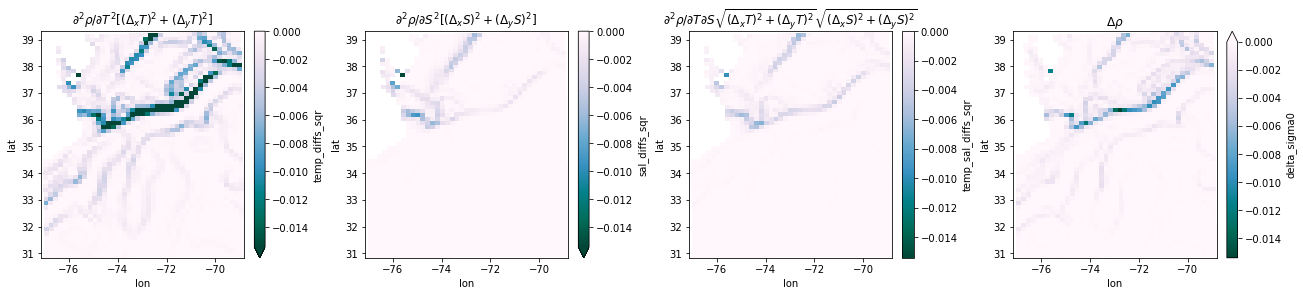

In [293]:
fig, ax = plt.subplots(ncols=4, constrained_layout=True, figsize=(18,4))
norm = colors.Normalize(vmin=dataLR.isel(time_counter=time_counter_to_plot).delta_sigma0[slice_cut].min().values, vmax=0.)
color_map='PuBuGn_r'
(dataLR.isel(time_counter=time_counter_to_plot)).temp_diffs_sqr[slice_cut].plot(ax=ax[0],x='lon', y='lat', norm=norm, cmap=color_map)
ax[0].set(title=r'$\partial^2 \rho/\partial T^2 [(\Delta_x T)^2 + (\Delta_y T)^2]$')
(dataLR.isel(time_counter=time_counter_to_plot)).sal_diffs_sqr[slice_cut].plot(ax=ax[1],x='lon', y='lat', norm=norm, cmap=color_map)
ax[1].set(title=r'$\partial^2 \rho/\partial S^2 [(\Delta_x S)^2 + (\Delta_y S)^2]$')
(dataLR.isel(time_counter=time_counter_to_plot)).temp_sal_diffs_sqr[slice_cut].plot(ax=ax[2],x='lon', y='lat', norm=norm, cmap=color_map)
ax[2].set(title=r'$\partial^2 \rho/\partial T \partial S \sqrt{(\Delta_x T)^2 + (\Delta_y T)^2} \sqrt{(\Delta_x S)^2 + (\Delta_y S)^2}$')
(dataLR.isel(time_counter=time_counter_to_plot)).delta_sigma0[slice_cut].plot(ax=ax[3],x='lon', y='lat', norm=norm, cmap=color_map)
ax[3].set(title=r'$\Delta \rho$')

plt.show()

# Spatial covariance

In [294]:
# %time corr_temp_grad = xr.corr(dataLR.temp_grad, -dataLR.dens_anomaly, dim=['x', 'y']).compute()
# corr_temp_grad.to_netcdf("Data/corr_temp_grad_winter.nc")

In [295]:
# corr_temp_grad = xr.open_dataarray("Data/corr_temp_grad_winter.nc")

In [ ]:
%time corr_temp_diffs_sqr = xr.corr(dataLR['temp_diffs_sqr'],\
                                       dataLR.delta_sigma0, dim=['x', 'y']).compute()

In [ ]:
corr_temp_diffs_sqr.to_netcdf("Data/region1_filter_15km_coarse_12/corr_temp_diffs_sqr_summer.nc")

In [ ]:
%time corr_sal_diffs_sqr = xr.corr(dataLR['sal_diffs_sqr'],\
                                       dataLR.delta_sigma0, dim=['x', 'y']).compute()

In [ ]:
corr_sal_diffs_sqr.to_netcdf("Data/region1_filter_15km_coarse_12/corr_sal_diffs_sqr_summer.nc")

In [ ]:
%time corr_temp_sal_diffs_sqr = xr.corr(dataLR['temp_diffs_sqr']+dataLR['sal_diffs_sqr'],\
                                       dataLR.delta_sigma0, dim=['x', 'y']).compute()

In [ ]:
corr_temp_sal_diffs_sqr.to_netcdf("Data/region1_filter_15km_coarse_12/corr_temp_sal_diffs_sqr_summer.nc")

In [ ]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
(corr_temp_diffs_sqr).plot(label=r'$\partial^2 \rho/\partial T^2 (\Delta T)^2$')
#(corr_sal_diffs_sqr).plot(label=r'$\partial^2 \rho/\partial S^2 (\Delta S)^2$')
#(corr_temp_sal_diffs_sqr).plot(label=r'$\partial^2 \rho/\partial T^2 (\Delta T)^2 + \partial^2 \rho/\partial S^2 (\Delta S)^2$')
ax.set(title=r'Spatial correlation with $\Delta \rho$')
ax.legend()
#plt.savefig("corr_delta_rho_vs_nabla_s_nabla_b.png")
plt.show()

# Non-dimensionalization of data

In [185]:
delta_sigma_max = 0.1

In [186]:
delta_sigma_max

0.1

In [187]:
rho_coef = 1./delta_sigma_max

In [188]:
dataLR['nondim_delta_sigma0'] = dataLR.delta_sigma0 * rho_coef

In [189]:
dataLR['nondim_CT'] = dataLR['CT']*np.sqrt(np.abs(dataLR['rho_ct_ct']/delta_sigma_max))
dataLR['nondim_sal'] = dataLR['sal']*np.sqrt(np.abs(dataLR['rho_sa_sa']/delta_sigma_max))

In [190]:
dataLR['nondim_CT_diff_x'] = diffs_x(dataLR['nondim_CT'])
dataLR['nondim_CT_diff_y'] = diffs_y(dataLR['nondim_CT'])

In [191]:
dataLR['nondim_sal_diff_x'] = diffs_x(dataLR['nondim_sal'])
dataLR['nondim_sal_diff_y'] = diffs_y(dataLR['nondim_sal'])

# Histograms

In [192]:
nb_of_bins = 200

In [193]:
bins_delta_sigma = np.linspace(-1., 0.)

In [194]:
x = dataLR['nondim_CT_diff_x']**2 + dataLR['nondim_CT_diff_y']**2

In [195]:
x.name = 'x'

In [196]:
bins_x = np.linspace(x.isel(time_counter=time_counter_to_plot).min().values, \
                             1.2*x.isel(time_counter=time_counter_to_plot).max().values, nb_of_bins)

In [197]:
%time hist_diffs_temp_sqr = histogram(dataLR.nondim_delta_sigma0[slice_cut], x[slice_cut], \
                                 bins=[bins_delta_sigma, bins_x]).compute()

CPU times: user 48.9 s, sys: 739 ms, total: 49.7 s
Wall time: 11min 43s


In [198]:
hist_diffs_temp_sqr.to_netcdf("Data/region1_filter_20km_coarse_12/hist_diffs_temp_sqr_summer.nc")

In [199]:
#hist_diffs_temp_sqr_winter = xr.open_dataarray("Data/hist_diffs_temp_sqr_winter.nc")

[(0.0, 1.0), (-1.0, 0.0), Text(0.5, 0, 'Bins $(\\Delta T^\\prime)^2$')]

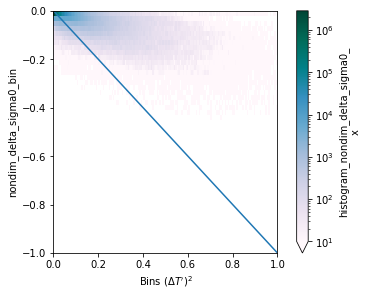

In [202]:
max_counter = hist_diffs_temp_sqr.max()

fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
hist_diffs_temp_sqr.plot(ax=ax
                         , norm=colors.LogNorm(vmin=10, vmax=max_counter), cmap='PuBuGn')
ax.plot(hist_diffs_temp_sqr_winter.x_bin, -1*hist_diffs_temp_sqr_winter.x_bin)
ax.set(xlim=[0,1.0], ylim=[-1.,0], xlabel=r'Bins $(\Delta T^\prime)^2$')

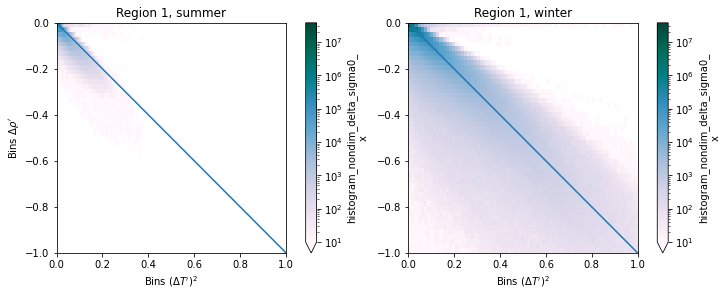

In [145]:
# max_counter = hist_diffs_temp_sqr.max()

# fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
# hist_diffs_temp_sqr.plot(ax=ax[0], norm=colors.LogNorm(vmin=10, vmax=max_counter), cmap='PuBuGn')
# hist_diffs_temp_sqr_winter.plot(ax=ax[1], norm=colors.LogNorm(vmin=10, vmax=max_counter), cmap='PuBuGn')
# ax[0].set(title='Region 1, summer')
# ax[1].set(title='Region 1, winter')
# for axis in ax :
#     axis.plot(hist_diffs_temp_sqr_winter.x_bin, -1*hist_diffs_temp_sqr_winter.x_bin)
#     axis.set(xlim=[0,1.0], ylim=[-1.,0], xlabel=r'Bins $(\Delta T^\prime)^2$')
# ax[0].set(ylabel=r'Bins $\Delta \rho^\prime$')
# ax[1].set(ylabel='')
# plt.savefig('histograms_region1_winter_summer.png')